In [104]:
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np
import json

## Clean the Grid Dataframe

In [168]:
pgh_grid = pd.read_csv('../Data/PGH/pgh_grid.csv')
pgh_grid = pgh_grid.rename(columns={'Unnamed: 0': 'cell_num'})
pgh_grid['tractce10'] = pgh_grid.tractce10.astype(str)

for row,col in pgh_grid.iterrows():
    pgh_grid.at[row, 'geometry'] = shapely.wkt.loads(pgh_grid.loc[row]['geometry'])
    pgh_grid.at[row, 'centroid'] = shapely.wkt.loads(pgh_grid.loc[row]['centroid'])
    
#     poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    
    tract = pgh_grid.loc[row]['tractce10'].split('.')
    tract = tract[0]
    
    if len(tract) < 6 and tract != 'nan':
        tract = '0' + tract
    
    pgh_grid.at[row, 'tractce10'] = tract

In [170]:
type(pgh_grid.loc[0]['geometry'])

shapely.geometry.polygon.Polygon

In [106]:
pgh_grid

,cell_num,geometry,centroid,stations,capacity,ids,tractce10
0,0,"POLYGON ((-80.09992749314026 40.3616104190275,...",POINT (-80.09763209887167 40.36390581329607),0,0,set(),nan
1,1,POLYGON ((-80.09992749314026 40.36620120756465...,POINT (-80.09763209887167 40.36849660183323),0,0,set(),nan
2,2,"POLYGON ((-80.09992749314026 40.3707919961018,...",POINT (-80.09763209887167 40.37308739037038),0,0,set(),nan
3,3,POLYGON ((-80.09992749314026 40.37538278463895...,POINT (-80.09763209887167 40.37767817890753),0,0,set(),nan
4,4,"POLYGON ((-80.09992749314026 40.3799735731761,...",POINT (-80.09763209887167 40.38226896744467),0,0,set(),nan
...,...,...,...,...,...,...,...
1659,1659,POLYGON ((-79.86579727774522 40.48556170953056...,POINT (-79.86350188347664 40.48785710379914),0,0,set(),nan
1660,1660,POLYGON ((-79.86579727774522 40.49015249806772...,POINT (-79.86350188347664 40.49244789233629),0,0,set(),nan
1661,1661,POLYGON ((-79.86579727774522 40.49474328660487...,POINT (-79.86350188347664 40.49703868087344),0,0,set(),nan
1662,1662,POLYGON ((-79.86579727774522 40.49933407514202...,POINT (-79.86350188347664 40.50162946941058),0,0,set(),nan


## Clean the Census Dataframes

In [171]:
#fix tract number for PGH
def fixtract(df, column):
    for row, col in df.iterrows():
        #fix census tract number
        tract = df.loc[row][column]
        if len(tract) < 6:
            tract = '0' + tract
        df.at[row, column] = tract
        
    return df

In [172]:
def addpercent_commuting(cm_df):
    cm_df['perc_public'] = cm_df['public_transit'] / cm_df['Workers_16yrs+']
    cm_df['perc_alone'] = cm_df['own_alone'] / cm_df['Workers_16yrs+']
    cm_df['perc_walk'] = cm_df['walked'] / cm_df['Workers_16yrs+']
    cm_df['perc_other'] = cm_df['other'] / cm_df['Workers_16yrs+']
    
    
    
    return cm_df

In [173]:
def addpercent_employment(employ_df):
    employ_df['perc_employed'] = employ_df['employed'] / employ_df['population_16yrs+']
    employ_df['perc_unemployed'] = employ_df['unemployed'] / employ_df['population_16yrs+']
    
    return employ_df

In [174]:
income_df = pd.read_csv('../Data/CensusTractData/income_data_pa.csv')
employment_df = pd.read_csv('../Data/CensusTractData/employment_data_pa.csv')
commuting_df = pd.read_csv('../Data/CensusTractData/commuting_data_pa.csv')

#commuting data
commuting_df['tractce10'] = commuting_df.tractce10.astype(str)
commuting_df = fixtract(commuting_df, 'tractce10')
commuting_df = addpercent_commuting(commuting_df)

#income data
income_df['tractce10'] = income_df.tractce10.astype(str)
income_df = fixtract(income_df, 'tractce10')

for row, col in income_df.iterrows():
    if income_df.loc[row]['mean_hh_income'] == '-' or income_df.loc[row]['mean_hh_income'] == 'N':
        income_df.at[row,'mean_hh_income'] = 0

income_df['mean_hh_income'] = income_df.mean_hh_income.astype(int)

#employment data
employment_df['tractce10'] = employment_df.tractce10.astype(str)
employment_df = fixtract(employment_df, 'tractce10')
employment_df = addpercent_employment(employment_df)

In [175]:
pgh_grid.head(1)

,cell_num,geometry,centroid,stations,capacity,ids,tractce10
0,0,"POLYGON ((-80.09992749314026 40.3616104190275,...",POINT (-80.09763209887167 40.36390581329607),0,0,set(),nan


In [176]:
len(pgh_grid)

1664

## Clean Outflow Dataframe

In [177]:
outflow = pd.read_csv('../Data/PGH/outflow_pgh_yearly.csv')
outflow = outflow.drop(columns=['Unnamed: 0'])
outflow = outflow.rename(columns={'2018-12-31 00:00:00': '2018_outflow', '2019-12-31 00:00:00': '2019_outflow', '2020-12-31 00:00:00': '2020_outflow'})
outflow['tractce10'] = outflow.tractce10.astype(str)
outflow = fixtract(outflow, 'tractce10')
outflow.head(3)

,station_id,tractce10,2018_outflow,2019_outflow,2020_outflow,pred_outflow
0,1000,020100,3834.0,4126.0,5204.0,4388
1,1001,020100,3654.0,3301.0,2415.0,3123
2,1002,020100,1498.0,1302.0,1033.0,1277


In [178]:
station_location = pd.read_csv('../Data/bikes_station_location.csv')
outflow = pd.merge(outflow, station_location, left_on = 'station_id', right_on = 'Station #')
outflow = outflow.drop(columns=['Station #', 'Latitude', 'Longitude', 'Station Name'])
outflow

,station_id,tractce10,2018_outflow,2019_outflow,2020_outflow,pred_outflow,NumRacks,coordinates
0,1000,020100,3834.0,4126.0,5204.0,4388,16,POINT (-80.004679 40.441326)
1,1001,020100,3654.0,3301.0,2415.0,3123,19,POINT (-80.00308 40.440877)
2,1002,020100,1498.0,1302.0,1033.0,1277,15,POINT (-80.00185999999999 40.43903)
3,1003,020100,1310.0,976.0,612.0,966,15,POINT (-80.00037500000001 40.4372)
4,1004,020100,1262.0,1212.0,1077.0,1183,15,POINT (-79.997102 40.435887)
...,...,...,...,...,...,...,...,...
95,49781,010300,18.0,191.0,157.0,122,6,POINT (-79.98117685 40.43829598)
96,49801,240600,NaN,593.0,1572.0,1082,6,POINT (-79.99094009 40.45379691)
97,49881,250300,19.0,433.0,330.0,260,5,POINT (-80.00945806999999 40.45777261)
98,49921,981200,29.0,587.0,948.0,521,5,POINT (-80.01206517 40.44741245)


In [179]:
for row,col in outflow.iterrows():
    outflow.at[row, 'coordinates'] = shapely.wkt.loads(outflow.loc[row]['coordinates'])

### Merge Income Dataframe with Grid Dataframe

In [180]:
pgh_grid_income = pgh_grid.merge(income_df, on='tractce10')
len(pgh_grid_income)

728

In [181]:
pgh_grid_income = pgh_grid_income.merge(employment_df, on='tractce10')
pgh_grid_income = pgh_grid_income.merge(commuting_df, on='tractce10')
pgh_grid_income

,cell_num,geometry,centroid,stations,capacity,ids,tractce10,Unnamed: 0_x,total_households,<$10K,...,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,POLYGON ((-79.87497885481953 40.44883540123336...,POINT (-79.87268346055095 40.45113079550194),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0
724,1588,POLYGON ((-79.87497885481953 40.45342618977051...,POINT (-79.87268346055095 40.45572158403908),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0
725,1589,POLYGON ((-79.87497885481953 40.45801697830766...,POINT (-79.87268346055095 40.46031237257623),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0
726,1619,POLYGON ((-79.87038806628237 40.44883540123336...,POINT (-79.8680926720138 40.45113079550194),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0


In [182]:
pgh_grid_income = pgh_grid_income.drop(columns=['17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', 'ids',
       'med_earnings_male_full-time', 'med_earnings_female_full-time','Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'])
pgh_grid_income.head(5)

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0


In [183]:
pgh_grid_income['2018_outflow'] = 0
pgh_grid_income['2019_outflow'] = 0
pgh_grid_income['2020_outflow'] = 0
pgh_grid_income['pred_outflow'] = 0

for row,col in outflow.iterrows():
    for r,c in pgh_grid_income.iterrows():
        if outflow.loc[row]['coordinates'].within(pgh_grid_income.loc[r]['geometry']):
            if pd.isna(outflow.loc[row]['2018_outflow']):
                pgh_grid_income.at[r,'2018_outflow'] = 0
            else:
                pgh_grid_income.at[r,'2018_outflow'] += outflow.loc[row]['2018_outflow']
            
            if pd.isna(outflow.loc[row]['2019_outflow']):
                pgh_grid_income.at[r,'2019_outflow'] = 0
            else:
                pgh_grid_income.at[r,'2019_outflow'] += outflow.loc[row]['2019_outflow']
                
            if pd.isna(outflow.loc[row]['2020_outflow']):
                pgh_grid_income.at[r,'2020_outflow'] = 0
            else:
                pgh_grid_income.at[r,'2020_outflow'] += outflow.loc[row]['2020_outflow']
            
            pgh_grid_income.at[r,'pred_outflow'] += outflow.loc[row]['pred_outflow']
            
pgh_grid_income

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other,2018_outflow,2019_outflow,2020_outflow,pred_outflow
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,POLYGON ((-79.87497885481953 40.44883540123336...,POINT (-79.87268346055095 40.45113079550194),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0
724,1588,POLYGON ((-79.87497885481953 40.45342618977051...,POINT (-79.87268346055095 40.45572158403908),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0
725,1589,POLYGON ((-79.87497885481953 40.45801697830766...,POINT (-79.87268346055095 40.46031237257623),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0
726,1619,POLYGON ((-79.87038806628237 40.44883540123336...,POINT (-79.8680926720138 40.45113079550194),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0


In [120]:
pgh_grid_income.to_csv('../Data/PGH/DemandPrediction/pgh_grid_fit.csv')

728 cells out of the 1664 cells centroids are within a census tract. Going to visualize where the cells are located to confirm. It is possible that we are missing at most 2 bike stations due to how the grid cell was created.

In [185]:
geo_cells = gpd.GeoDataFrame(pgh_grid_income, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])
geo_cells

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other,2018_outflow,2019_outflow,2020_outflow,pred_outflow
0,51,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
1,52,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
2,82,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
3,83,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
4,84,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,"POLYGON ((-79.87498 40.44884, -79.87498 40.453...",POINT (-79.87268346055095 40.45113079550194),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0
724,1588,"POLYGON ((-79.87498 40.45343, -79.87498 40.458...",POINT (-79.87268346055095 40.45572158403908),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0
725,1589,"POLYGON ((-79.87498 40.45802, -79.87498 40.462...",POINT (-79.87268346055095 40.46031237257623),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0
726,1619,"POLYGON ((-79.87039 40.44884, -79.87039 40.453...",POINT (-79.8680926720138 40.45113079550194),0,0,130600,1391,240,258,161,...,179,26,0.181051,0.545028,0.000000,0.0,0,0,0,0


Text(0.5, 1.0, '2018 Outflow: # of Bikes Leaving Stations by Grid Cell')

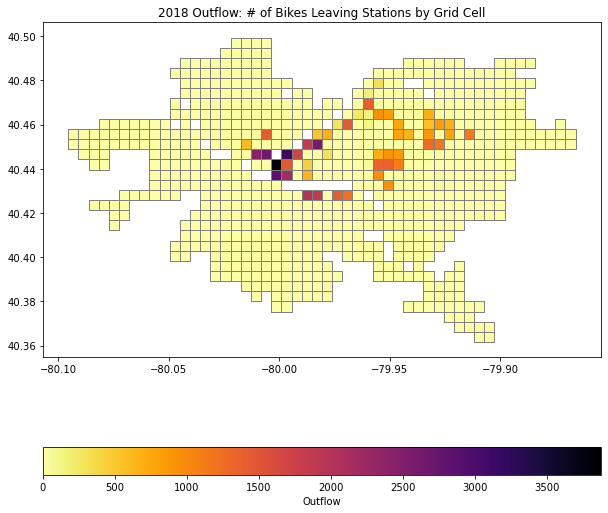

In [204]:
geo_cells.plot(column="2018_outflow", cmap='inferno_r',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("2018 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, '2019 Outflow: # of Bikes Leaving Stations by Grid Cell')

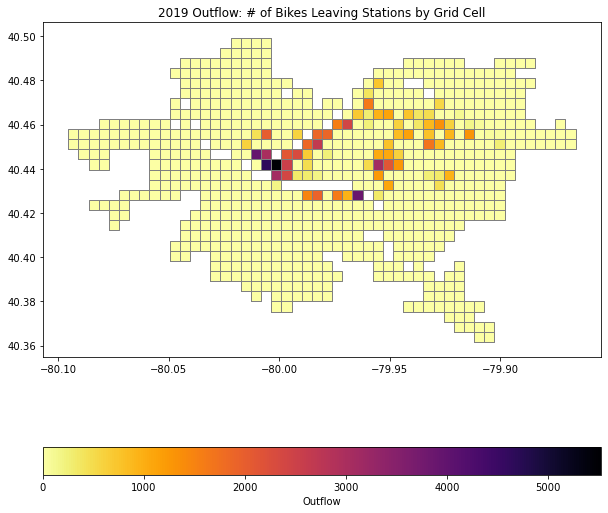

In [205]:
geo_cells.plot(column="2019_outflow", cmap='inferno_r',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("2019 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, '2020 Outflow: # of Bikes Leaving Stations by Grid Cell')

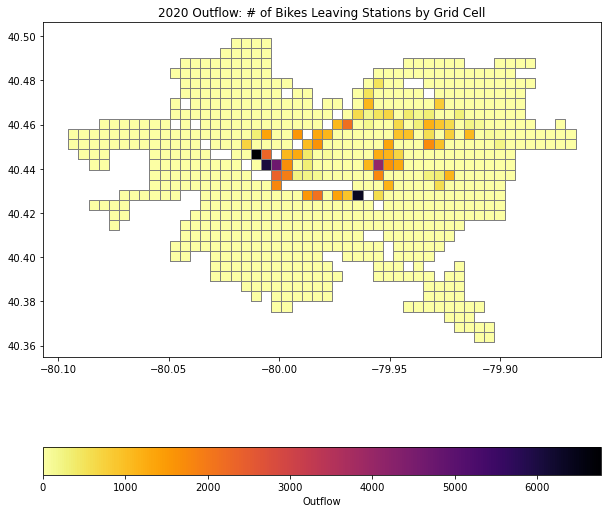

In [201]:
geo_cells.plot(column="2020_outflow", cmap='inferno_r',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("2020 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell')

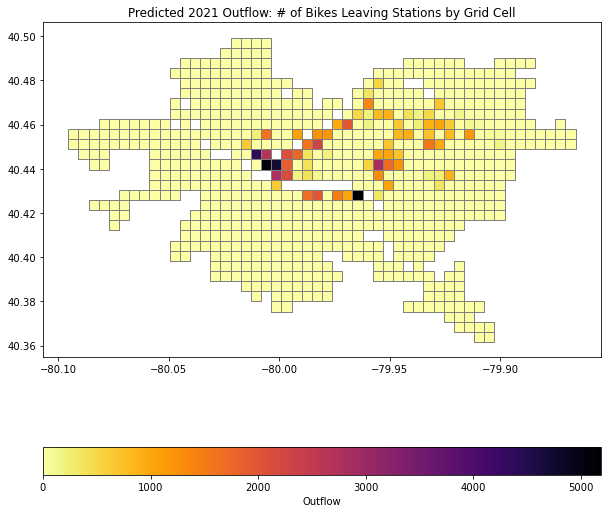

In [206]:
geo_cells.plot(column="pred_outflow", cmap='inferno_r',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell")

The predicted outflow which is a proxy for demand of bikes in a grid cell of Pittsburgh is not solely predicting demand for locations that currently have bike stations. The prediction of a grid cell is the mean of the outflow over the last three years. Below we create a proxy for demand for areas that curently don't have bike stations to see how those areas are.

In [213]:
cells_tract_dict = {}

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['tractce10'] in cells_tract_dict.keys():
        cells_tract_dict[geo_cells.loc[row]['tractce10']] += 1
    else:
        cells_tract_dict[geo_cells.loc[row]['tractce10']] = 1

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['stations'] == 0:
        #create a proxy for demand
        geo_cells.at[row,'pred_outflow'] = (geo_cells.loc[row]['population_16yrs+'] / cells_tract_dict[geo_cells.loc[row]['tractce10']])

In [216]:
geo_cells.head(5)

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other,2018_outflow,2019_outflow,2020_outflow,pred_outflow
0,51,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
1,52,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
2,82,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
3,83,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
4,84,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133


Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell')

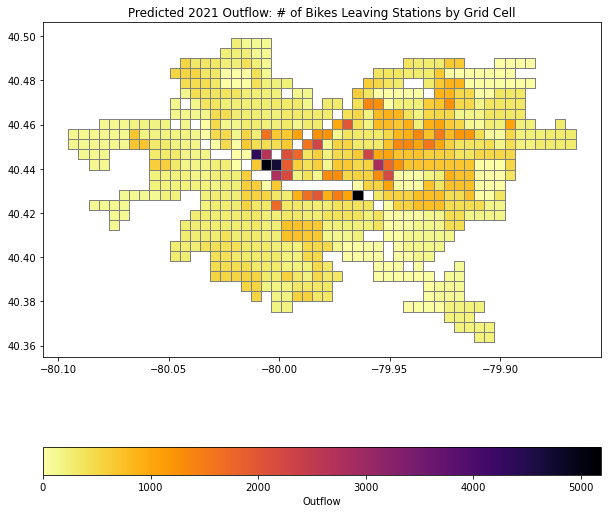

In [217]:
geo_cells.plot(column="pred_outflow", cmap='inferno_r',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell")

The above predicted outflow is incorporating the population 16yrs+ in the census tract that the grid cell centroid falls within and is divided by the number of cells that fall within that census tract. This is only calculated for cells that did not previously have bike stations.

In [219]:
cells_tract_dict = {}

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['tractce10'] in cells_tract_dict.keys():
        cells_tract_dict[geo_cells.loc[row]['tractce10']] += 1
    else:
        cells_tract_dict[geo_cells.loc[row]['tractce10']] = 1

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['stations'] == 0:
        #create a proxy for demand
        geo_cells.at[row,'pred_outflow'] = (geo_cells.loc[row]['population_16yrs+'] / cells_tract_dict[geo_cells.loc[row]['tractce10']]) - (geo_cells.loc[row]['own_alone'] / cells_tract_dict[geo_cells.loc[row]['tractce10']])

Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell')

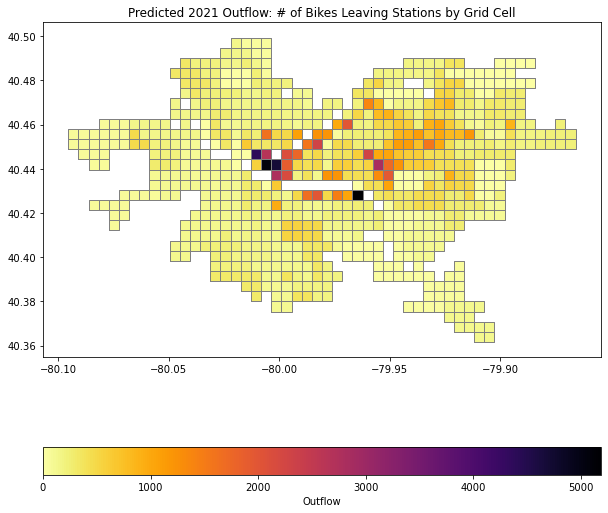

In [220]:
geo_cells.plot(column="pred_outflow", cmap='inferno_r',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell")

The above predicted outflow is incorporating the population 16yrs+ in the census tract that the grid cell centroid falls within and is divided by the number of cells that fall within that census tract minus the number of people who reported traveling to work alone divided by the number of cells that fall within that census tract. This is only calculated for cells that did not previously have bike stations. The helps adjust for those areas that are purely rural or suburban in or around Pittsburgh.

In [218]:
geo_cells.columns

Index(['cell_num', 'geometry', 'centroid', 'stations', 'capacity', 'tractce10',
       'total_households', '<$10K', '$10K-15K', '$15K-25K', '$25K-35K',
       '$35K-50K', '$50K-75K', '$75K-100K', '$100K-150K', '$150K-200K',
       '>$200K', 'median_hh_income', 'mean_hh_income', '13_x', '14_x', '15_x',
       '16_x', 'population_16yrs+', 'in_labor_force', 'civ_labor_force',
       'employed', 'unemployed', 'armed forces', 'not_in_labor_force',
       'civ_labor_force.1', 'females_16yr+', 'in_labor_force.1',
       'civ_labor_force.2', 'employed.1', '13_y', '14_y', '15_y', '16_y',
       'perc_employed', 'perc_unemployed', 'Workers_16yrs+', 'own_alone',
       'carpool', 'public_transit', 'walked', 'other', 'wfh',
       'mean_travel_time_to_work', 'perc_public', 'perc_alone', 'perc_walk',
       'perc_other', '2018_outflow', '2019_outflow', '2020_outflow',
       'pred_outflow'],
      dtype='object')

In [222]:
ml_df = geo_cells.drop(columns=['cell_num', 'geometry', 'centroid', 'stations', 'capacity', 'tractce10',
                               '<$10K', '$10K-15K', '$15K-25K', '$25K-35K','$35K-50K', '$50K-75K', '$75K-100K', 
                                '$100K-150K', '$150K-200K','>$200K', '13_x', '14_x', '15_x','16_x','armed forces', 
                                'not_in_labor_force','civ_labor_force.1', 'females_16yr+', 'in_labor_force.1',
                                'civ_labor_force.2', 'employed.1', '13_y', '14_y', '15_y', '16_y'])
ml_df.to_csv('../Data/PGH/DemandPrediction/ml_df.csv')